In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import numpy as np 
import copy
import pickle
from pathlib import Path
import gym 

# rendering gym env
from IPython import display
import matplotlib
%matplotlib inline

## PPO Implementation

In [6]:
def Network(input_tensor, output_size, scope, fsize, conv_depth, n_hidden_dense=0, activation=tf.tanh, output_activation=None):
        with tf.variable_scope(scope):
            x = input_tensor
            # Convolutions
            for _ in range(conv_depth):
                x = tf.layers.conv2d(x, fsize, (3, 3), activation='relu')
                x = tf.layers.conv2d(x, fsize, (3, 3), strides=(2, 2))
            
            # Dense Layers
            x = tf.layers.flatten(x)
            for _ in range(n_hidden_dense):
                x = tf.layers.dense(x, fsize, activation=activation)
            y = tf.layers.dense(x, output_size, activation=output_activation)
        return y

In [7]:

class Policy(object):
    def __init__(self, graph_args, adv_args):
        self.ob_dim = graph_args['ob_dim']
        self.act_dim = graph_args['act_dim']
        clip_range = graph_args['clip_range']
        # conv operations params
        conv_depth = graph_args['conv_depth']
        filter_size = graph_args['filter_size']
        
        self.learning_rate = graph_args['learning_rate']
        self.num_target_updates = graph_args['num_target_updates']
        self.num_grad_steps_per_target_update = graph_args['num_grad_steps_per_target_update']
        
        self.gamma = adv_args['gamma']
        
        self.obs, self.act, self.adv, self.old_logprob = self.define_placeholders()
        
        # policy / actor evaluation
        self.policy_distrib = Network(self.obs, self.act_dim, 'policy', filter_size, conv_depth)
        self.greedy_action = tf.argmax(self.policy_distrib, axis=1)
        self.logprob = self.get_logprob(self.policy_distrib, self.act)
        
        # importance sampling
        ratio = tf.exp(self.logprob - self.old_logprob)
        clipped_ratio = tf.clip_by_value(ratio, 1.0-clip_range, 1.0+clip_range)        
        # include increase entropy term with alpha=0.2
        batch_loss = tf.minimum(ratio*self.adv, clipped_ratio * self.adv) - 0.2 * self.logprob
        self.actor_loss = -1 * tf.reduce_mean(batch_loss)
        self.actor_update_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.actor_loss)
        
        # critic definition
        self.v_pred = tf.squeeze(Network(self.obs, 1, 'critic', filter_size, conv_depth, n_hidden_dense=2))
        self.v_target = tf.placeholder(shape=(None,), name='v_target', dtype=tf.float32)
        self.critic_loss = tf.losses.mean_squared_error(self.v_target, self.v_pred)
        # minimize with respect to correct variables HERE
        self.critic_update_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.critic_loss)
        
    def set_session(self, sess):
        self.sess = sess
        
    def define_placeholders(self):
        obs = tf.placeholder(shape=((None,) + (self.ob_dim)), name='obs', dtype=tf.float32)
        act = tf.placeholder(shape=(None,), name='act', dtype=tf.int32)
        adv = tf.placeholder(shape=(None,), name='adv', dtype=tf.float32)
        logprob = tf.placeholder(shape=(None,), name='logprob', dtype=tf.float32)
        return obs, act, adv, logprob
    
    def get_logprob(self, policy_distribution, actions):
        action_enc = tf.one_hot(actions, depth=self.act_dim)
        logprob = -1 * tf.nn.softmax_cross_entropy_with_logits_v2(logits=policy_distribution, labels=action_enc)
        return logprob
        
    def get_best_action(self, observation):
        act = sess.run(self.greedy_action, feed_dict={
            self.obs: [observation]
        })[0]
        return act
    
    def estimate_adv(self, obs, rew, nxt_obs, dones):
        ## Markov Implementation??
        # V(s) & V(s')
        v_obs = self.sess.run(self.v_pred, feed_dict={self.obs: obs})
        v_nxt_obs = self.sess.run(self.v_pred, feed_dict={self.obs: nxt_obs})
        # y = r + gamma * V(s')
        y_obs = rew + (1 - dones) * self.gamma * v_nxt_obs
        # Adv(s) = y - V(s)
        adv = y_obs - v_obs
        # Normalize advantages
        adv = (adv - np.mean(adv)) / (np.std(adv) + 1e-8)
        return adv
    
    def train_actor(self, obs, act, logprob, adv):
        self.sess.run(self.actor_update_op, feed_dict={
            self.obs: obs,
            self.act: act,
            self.adv: adv,
            self.old_logprob: logprob
        })
        
    def train_critic(self, obs, nxt_obs, rew, dones):
        for i in range(self.num_grad_steps_per_target_update * self.num_target_updates):
            if i % self.num_grad_steps_per_target_update == 0:
                v_pred = self.sess.run(self.v_pred, feed_dict={self.obs: nxt_obs})
                y = rew + self.gamma * v_pred * (1 - dones)
                
            _, loss = self.sess.run([self.critic_update_op, self.critic_loss],
                                    feed_dict={self.obs: obs, self.v_target: y})

In [8]:

class ReplayBuffer(object):
    def __init__(self, max_size=10000):
        self.obs = []
        self.acts = []
        self.rewards = []
        self.nxt_obs = []
        self.dones = []
        self.logprobs = []
        self.max_size = max_size
    
    def record(self, obs, act, rew, nxt_ob, done):
        self.obs.append(obs)
        self.acts.append(act)
        self.rewards.append(rew)
        self.nxt_obs.append(nxt_ob)
        self.dones.append(done)
        
    def get_actions(self):
        return np.asarray(self.obs), np.asarray(self.acts)
    
    def set_logprobs(self, logprobs):
        self.logprobs += list(logprobs)
        assert len(self.logprobs) == len(self.obs), 'logprobs MUST == self.obs'
        
    def merge(self, obs, acts, rews, nxt_obs, dones, logprobs):
        self.obs += obs
        self.acts += acts
        self.rewards += rews
        self.nxt_obs += nxt_obs
        self.dones += dones
        self.logprobs += list(logprobs)
    
    def export(self):
        return self.obs, self.acts, self.rewards, self.nxt_obs, self.dones, self.logprobs
    
    def get_samples(self, indices):
        return (
            np.asarray(self.obs)[indices],
            np.asarray(self.acts)[indices],
            np.asarray(self.rewards)[indices],
            np.asarray(self.nxt_obs)[indices],
            np.asarray(self.dones)[indices],
            np.asarray(self.logprobs)[indices]
        )

    def get_all(self, batch_size):
        batched_dsets = []
        # batch up data
        for dset in [np.asarray(self.obs), np.asarray(self.acts), np.asarray(self.rewards), np.asarray(self.nxt_obs), np.asarray(self.dones), np.asarray(self.logprobs)]:
            bdset = []
            for i in range(0, len(dset), batch_size):
                 bdset.append(np.array(dset[i:i+batch_size]))
            batched_dsets.append(np.asarray(bdset))
        return tuple(batched_dsets)
    
    def update_size(self):
        diff = self.max_size - len(self)
        if diff < 0:
            # FIFO
            self.obs = self.obs[-diff:]
            self.acts = self.acts[-diff:]
            self.rewards = self.rewards[-diff:]
            self.nxt_obs = self.acts[-diff:]
            self.dones = self.dones[-diff:]
            self.logprobs = self.logprobs[-diff:]
    
    def flush(self):
        self.obs = []
        self.acts = []
        self.rewards = []
        self.nxt_obs = []
        self.dones = []
        self.logprobs = []
    
    def __len__(self):
        return len(self.obs)

In [2]:
class Logger(object):
    def __init__(self):
        self.tag = None
        self.totalr = []
        self.std_reward = []
        
        self.tags = []
        self.results = []
        
        self.fset = Path('iter-frames')
        self.fset.mkdir(exist_ok=True)
        self.n_frames_stored = 0
        
    def set_tag(self, tag):
        self.tag = tag
        
    def log(self, totalr, std):
        self.totalr.append(totalr)
        self.std_reward.append(std)
        
    def log_frames(self, frames):
        fname = '{}'.format(self.n_frames_stored)
        with open(self.fset/fname, 'wb') as f:
            pickle.dump(frames, f, protocol=pickle.HIGHEST_PROTOCOL)
            
        self.n_frames_stored += 1
        
    def package_results(self):
        # store
        self.tags.append(self.tag)
        self.results.append([self.totalr, self.std_reward])
    
    def flush(self):
        self.totalr = []
        self.std_reward = []

Simple Actor Critic Test On Cart-Pole

In [10]:
# for results in logger.results:
#     totalr, stdr = results[0], results[1]
#     plt.plot(totalr)
# plt.title('AvgTotalReward vs Train Iteration')
# plt.xlabel('TrainIteration')
# plt.ylabel('AvgTotalReward')
# plt.legend(logger.tags, loc='upper left')
# plt.show()

## Density Estimation

In [11]:
class DensityModel(object):
    def __init__(self, graph_args):
        # unpacking
        self.ob_dim = graph_args['ob_dim']
        self.learning_rate = graph_args['learning_rate']
        self.z_size = graph_args['z_size']
        self.kl_weight = graph_args['kl_weight']
        # network operations params
        self.hid_size = graph_args['hid_size']
        self.n_hidden = graph_args['n_hidden']
        
        self.state1, self.state2 = self.define_placeholders()
        # q(z_1 | s_1), q(z_2 | s_2), p(z), p(y | z)
        self.encoder1, self.encoder2, self.prior, self.discriminator = self.forward_pass(self.state1, self.state2)
        self.discrim_target = tf.placeholder(shape=[None, 1], name="discrim_target", dtype=tf.float32)

        self.log_likelihood = tf.squeeze(self.discriminator.log_prob(self.discrim_target), axis=1)
        self.likelihood = tf.squeeze(self.discriminator.prob(self.discrim_target), axis=1)
        
        self.kl = self.encoder1.kl_divergence(self.prior) + self.encoder2.kl_divergence(self.prior)

        assert len(self.log_likelihood.shape) == len(self.likelihood.shape) == len(self.kl.shape) == 1
        
        self.elbo = tf.reduce_mean(self.log_likelihood - self.kl_weight * self.kl)
        self.update_op = tf.train.AdamOptimizer(self.learning_rate).minimize(-self.elbo)

    def define_placeholders(self):
        state1 = tf.placeholder(shape=((None,) + (self.ob_dim)), name="s1", dtype=tf.float32)
        state2 = tf.placeholder(shape=((None,) + (self.ob_dim)), name="s2", dtype=tf.float32)
        return state1, state2
    
    def set_session(self, sess):
        self.sess = sess

    #Network(input_tensor, output_size, scope, fsize, conv_depth, n_hidden_dense=0, activation=tf.tanh, output_activation=None):
    def make_encoder(self, state, z_size, scope):
        """ Encodes the given state to z_size => create guass. distribution for q(z | s)
        """
        # conv operations
        z_mean = Network(state, z_size, scope, self.hid_size, conv_depth=self.n_hidden)
        z_logstd = tf.get_variable("logstd", shape=(z_size,)) 
        return tfp.distributions.MultivariateNormalDiag(loc=z_mean, scale_diag=tf.exp(z_logstd))

    def make_prior(self, z_size):
        """ Create Prior to map states too => p(z), we will use a normal guass distrib
        """
        prior_mean = tf.zeros((z_size,))
        prior_logstd = tf.zeros((z_size,))
        return tfp.distributions.MultivariateNormalDiag(loc=prior_mean, scale_diag=tf.exp(prior_logstd))

    def make_discriminator(self, z, output_size, scope, n_layers, hid_size):
        """ Predict D(z = [z1, z2]) => p(y | z)
        """
        logit = Network(z, output_size, scope, hid_size, conv_depth=0, n_hidden_dense=n_layers)
        return tfp.distributions.Bernoulli(logit)

    def forward_pass(self, state1, state2):
        # Reuse
        make_encoder1 = tf.make_template('encoder1', self.make_encoder)
        make_encoder2 = tf.make_template('encoder2', self.make_encoder)
        make_discriminator = tf.make_template('decoder', self.make_discriminator)

        # Encoder
        encoder1 = make_encoder1(state1, self.z_size, 'z1')
        encoder2 = make_encoder2(state2, self.z_size, 'z2')

        # Prior
        prior = self.make_prior(self.z_size)

        # Sampled Latent (some noise)
        self.z1 = encoder1.sample()
        z2 = encoder2.sample()
        z = tf.concat([self.z1, z2], axis=1)

        # Discriminator
        discriminator = make_discriminator(z, 1, 'discriminator', self.n_hidden, self.hid_size)
        return encoder1, encoder2, prior, discriminator

    def update(self, state1, state2, target):
        _, ll, kl, elbo = self.sess.run([self.update_op, self.log_likelihood, self.kl, self.elbo], feed_dict={
            self.state1: state1,
            self.state2: state2,
            self.discrim_target: target
        })
        return ll, kl, elbo
    
    def get_encoding(self, state):
        """Assuming only encode a single state at a time
        We will call this to use in our state dynamics fcn
        """
        return self.sess.run(self.z1, feed_dict={
            self.state1: [state]
        })[0]

    def get_likelihood(self, state1, state2):
        bs, _, _, _ = state1.shape
        target = np.zeros((bs, 1))
        for i, (s1, s2) in enumerate(zip(state1, state2)):
            if s1.all() == s2.all(): target[i] = [1]

        likelihood = self.sess.run(self.likelihood, feed_dict={
            self.state1: state1,
            self.state2: state2,
            self.discrim_target: target
        })
        return likelihood

    def get_prob(self, state):
        likelihood = self.get_likelihood(state, state)
        # avoid divide by 0 and log(0)
        likelihood = np.clip(np.squeeze(likelihood), 1e-5, 1-1e-5)
        prob = (1 - likelihood) / likelihood
        return prob
    
    def modify_reward(self, state, rewards):
        probs = self.get_prob(state)
        bonus = -np.log(probs)
        return rewards + 1e-3 * bonus

In [12]:
class Agent(object):
    def __init__(self, env, policy, density, replay_buffer, logger):
        self.env = env
        self.policy = policy
        self.density = density
        self.replay_buffer = replay_buffer
        self.logger = logger
        
    def set_session(self, sess):
        self.sess = sess
        self.policy.set_session(sess)
        self.density.set_session(sess)
        
    def sample_env(self, num_samples):
        obs = self.env.reset()
        i = 0
        while True:
            act = self.choose_action(obs)
            nxt_ob, rew, done, _ = env.step(act)
            
            replay_buffer.record(obs, act, rew, nxt_ob, done)
            obs = nxt_ob if not done else env.reset()
            i+=1
            if i == num_samples - 1: break
        
        # get logprobs of taking actions w.r.t current policy
        obs, actions = replay_buffer.get_actions()
        logprobs = sess.run(policy.logprob, feed_dict={
            policy.obs: obs,
            policy.act: actions
        })
        replay_buffer.set_logprobs(logprobs)
        replay_buffer.flush_temp()
        
    def choose_action(self, obs):
        # Greedy action for now
        return self.policy.get_best_action(obs)
            
    def train(self, batch_size):
        obs, acts, rewards, nxt_obs, dones, logprobs = self.replay_buffer.get_batch(batch_size)
        # inject exploration bonus
        rewards = self.density.modify_reward(obs, rewards)

        # train actor
        adv = policy.estimate_adv(obs, rewards, nxt_obs, dones)
        self.policy.train_actor(obs, acts, logprobs, adv)
        
        # train critic
        self.policy.train_critic(obs, nxt_obs, rewards, dones)
        
        # train density model
        s1, s2, target = self.replay_buffer.get_density_batch(obs, batch_size)
        self.density.update(s1, s2, target)
    
    def test(self, num_tests, render=False, max_steps=5000):
        obs = self.env.reset()
        frames = [self.env.render(mode='rgb_array')]
        i, step = 0, 0
        try:
            while i < num_tests:
                if render:
                    frames.append(env.render(mode='rgb_array'))
                act = self.policy.get_best_action(obs)
                nxt_ob, rew, done, _ = env.step(act)
                replay_buffer.record(obs, act, rew, nxt_ob, done)
                obs = nxt_ob
                if done or step > max_steps:
                    obs = env.reset()
                    i += 1
                    step = 0
                step += 1
        finally:
            self.env.close()
            
        totalr, stdr = replay_buffer.get_temp_reward_info()
        logger.log(totalr / i, stdr)
        logger.log_frames(frames)
        frames = []

In [13]:
# test density fcn 
env = gym.make('MontezumaRevenge-v0')
# default params taken from homework
d_graph_args = {
    'ob_dim': env.observation_space.shape,
    'learning_rate': 5e-3,
    'z_size': 32,
    'kl_weight': 1e-2,
    'conv_depth': 5,
    'hid_size': 32,
    'n_hidden': 4
}
p_graph_args = {
    'ob_dim': env.observation_space.shape,
    'act_dim': env.action_space.n,
    'clip_range': 0.2,
    'conv_depth': 5,
    'filter_size': 32,
    'learning_rate': 5e-3,
    'num_target_updates': 10,
    'num_grad_steps_per_target_update': 10
}
adv_args = {
    'gamma': 0.9999999
}

# build graph
# models
policy = Policy(p_graph_args, adv_args)
density_model = DensityModel(d_graph_args)
# utils
replay_buffer = MasterBuffer(max_size=50000)
logger = Logger()

# agent which will do all the work
agent = Agent(env, policy, density_model, replay_buffer, logger)

/home/brennan/anaconda2/envs/py3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [16]:
tf.reset_default_graph()

In [ ]:
tf_config = tf.ConfigProto(inter_op_parallelism_threads=1, intra_op_parallelism_threads=1)
# tf_config.gpu_options.allow_growth = True
with tf.Session(config=tf_config) as sess:
    sess.run(tf.global_variables_initializer())
    agent.set_session(sess)
    
    n_iter = 101
    num_samples = 200
    batch_sizes = [64]
    render_n = 50
    
    print('starting to train...')
    for bs in batch_sizes:
        logger.set_tag('bs: '+str(bs))
        replay_buffer.flush()
        
        for itr in range(n_iter):
            agent.sample_env(num_samples)
            agent.train(batch_size=bs)
            print('completed itr {}...\r'.format(str(itr)))
            if itr % render_n == 0 and itr != 0:
                agent.test(1, render=True)
                print('render complete...')
        logger.package_results()
        logger.flush()

starting to train...
completed itr 0...
completed itr 1...
completed itr 2...
completed itr 3...
completed itr 4...
completed itr 5...
completed itr 6...
completed itr 7...
completed itr 8...
completed itr 9...
completed itr 10...
completed itr 11...
completed itr 12...
completed itr 13...
completed itr 14...
completed itr 15...
completed itr 16...
completed itr 17...
completed itr 18...
completed itr 19...
completed itr 20...
completed itr 21...
completed itr 22...
completed itr 23...
completed itr 24...
completed itr 25...
completed itr 26...
completed itr 27...
completed itr 28...
completed itr 29...
completed itr 30...
completed itr 31...
completed itr 32...
completed itr 33...
completed itr 34...
completed itr 35...
completed itr 36...
completed itr 37...
completed itr 38...
completed itr 39...
completed itr 40...
completed itr 41...
completed itr 42...
completed itr 43...
completed itr 44...
completed itr 45...
completed itr 46...
completed itr 47...
completed itr 48...
completed

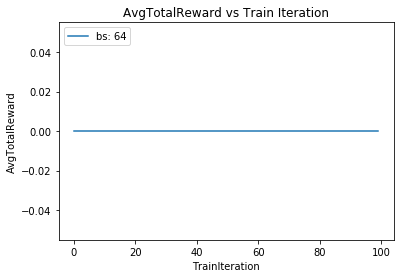

In [14]:
for results in logger.results:
    totalr, stdr = results[0], results[1]
    plt.plot(totalr)
plt.title('AvgTotalReward vs Train Iteration')
plt.xlabel('TrainIteration')
plt.ylabel('AvgTotalReward')
plt.legend(logger.tags, loc='upper left')
plt.show()

# TODO
- transport code to GPU environment to test density function
- split density training into seperate function <b>later</b>

In [27]:
import os

In [31]:
logs = list(Path('iter-frames').iterdir())
logs

[PosixPath('iter-frames/nsamples: 100-0'),
 PosixPath('iter-frames/WithoutNormBonus'),
 PosixPath('iter-frames/nsamples: 100-1')]

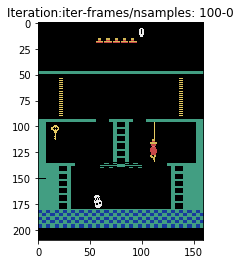

In [32]:
n_frames = 50
for fn in reversed(logs):
    if os.path.isfile(fn):
        with open(fn, 'rb') as file:
            frames = pickle.load(file)
    #         frames, rewards = data[0], data[1]
            # View 
            img = plt.imshow(frames[0])
            plt.title('Iteration:' + str(fn))
            for i, frame in enumerate(frames):
                img.set_data(frame) # just update the data
                display.display(plt.gcf())
                display.clear_output(wait=True)
                if i > n_frames: break          